# Lei (Raymond) Chi and Seong-Jun Yea NLP Final Project
**Topic: Language Identification System**

> *Which library (TensorFlow or PyTorch) did you use?*

TensorFlow and Keras were used for building and training neural network models. We also utilized transformers library's pretrained model: CardiffNLP's Twitter Models.

>*What task did you work on?*

The project's primary objective is constructing a language detection model. On a given sentence, this model returns a language of the sentence. We compared three types of text embedding on dataset for Feed-forward Neural Network model, and we tested CNN as well. Lastly as an extra detail, we implemented a sentiment analysis that tells you if the text is positive or negative.

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.callbacks import History
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, Input

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

import matplotlib.pyplot as plt
import seaborn as sns

2024-05-11 05:17:27.914885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 05:17:27.914997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 05:17:28.186482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


>*What dataset did you use?*

The dataset from Kaggle comprised samples of text annotated with their corresponding language labels. Each entry in the dataset included a sentence and a language label. Languages are such as English, Tamil, Dutch, Danish, Spanish, French, Italian, and Swedish. Here are a few examples from the dataset:



In [7]:
data_frame = pd.read_csv('/kaggle/input/language-detection/Language Detection.csv')
data_frame.sample(n=15, random_state=12345)

,Text,Language
1346,oh dear one night when she was sleeping her mo...,English
2184,சந்திப்பு அல்லது தேதி என்று சொல்வது மிகவும் பி...,Tamil
4718,wat dacht je van een ijsje?,Dutch
1041,i'm deluged with assignments smart word number...,English
6772,"han er så klar og suave, især foran damerne el...",Danish
6983,Jeg har ikke en mening om sagen.,Danish
2374,"என்னைப் பொருத்தவரை, இது நகரத்தின் சிறந்த உணவகம்.",Tamil
4856,Existe cierta polémica entre los fundadores de...,Spanish
4209,Veuillez accepter mes excuses.,French
7140,Wales cedette tutti i diritti alla fondazione ...,Italian


In [8]:
lang_distribution = data_frame["Language"].value_counts().reset_index()
lang_distribution.columns = ["Language", "Frequency"]
print(lang_distribution)

      Language  Frequency
0      English       1385
1       French       1014
2      Spanish        819
3   Portugeese        739
4      Italian        698
5      Russian        692
6     Sweedish        676
7    Malayalam        594
8        Dutch        546
9       Arabic        536
10     Turkish        474
11      German        470
12       Tamil        469
13      Danish        428
14     Kannada        369
15       Greek        365
16       Hindi         63


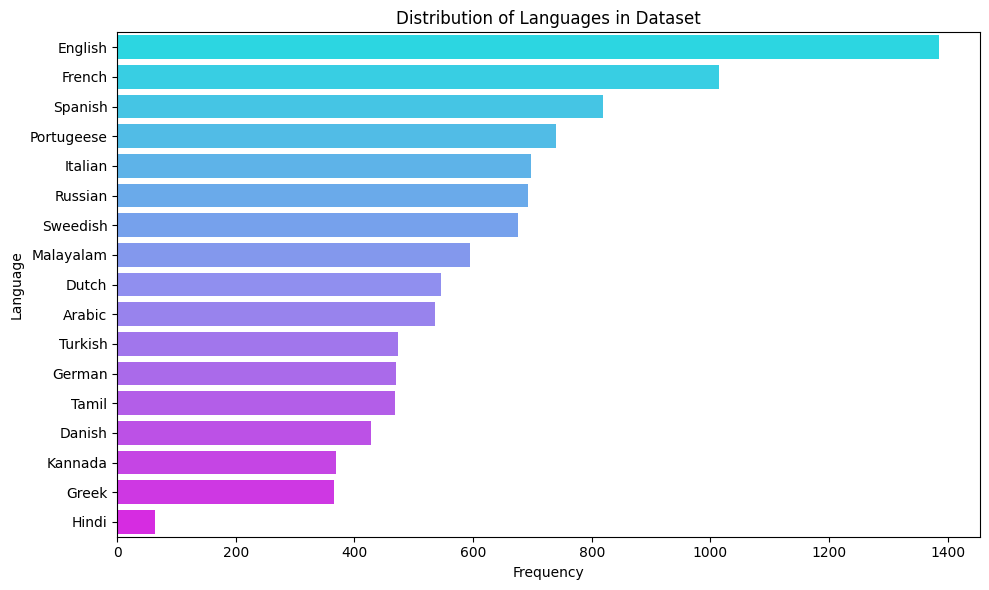

In [4]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Language', data=lang_distribution, palette='cool')
plt.xlabel('Frequency')
plt.ylabel('Language')
plt.title('Distribution of Languages in Dataset')
plt.tight_layout()
plt.show()

>*How was the dataset split into training, tuning, and testing portions?*

This line divides the dataset into training and testing sets, with 80% of the data used for training and 20% for testing. The random_state is set to 42 to ensure reproducibility of results. We include validation set for tunning as we're running model.fit and it is 20%. 

In [9]:
text_train, text_test, labels_train, labels_test = train_test_split(
    data_frame['Text'], data_frame['Language'], test_size=0.2, random_state=42)

In [11]:
# Label encoding
language_encoder = LabelEncoder() # categorical strings to integers
encoded_labels_train = language_encoder.fit_transform(labels_train)
encoded_labels_test = language_encoder.transform(labels_test)

In [22]:
# Vectorization: Bag of Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(text_train).toarray()
X_test_bow = bow_vectorizer.transform(text_test).toarray()

# Vectorization: TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(text_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(text_test).toarray()

# Vectorization: Doc2Vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(text_train.apply(lambda x: word_tokenize(x)))]
d2v_model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)
X_train_d2v = np.array([d2v_model.infer_vector(word_tokenize(text)) for text in text_train])
X_test_d2v = np.array([d2v_model.infer_vector(word_tokenize(text)) for text in text_test])

print(X_train_tfidf.shape[1], X_train_bow.shape[1], X_test_d2v.shape[1])

34808 34808 50


>*What architectures and other variables did you experiment with? (Include types of networks, types and sizes of layers, hyperparameters, etc.)*

**Architecture: Feedforward Neural Network (FNN)**
* Network Type: The model architecture is a multilayer perceptron (MLP), a type of feedforward neural network (FNN).
* Input Layer: The network takes an input whose dimensionality (input_dim) is determined by the output of the vectorization technique applied to the input data. tfidf - 34808, BoW - 34808, d2v - 50
* Hidden Layers:
    1. First Hidden Layer: Consists of 150 neurons, using the ReLU (Rectified Linear Unit) activation function. This layer is designed to capture non-linear relationships in the data.
    2. Second Hidden Layer: Comprises 75 neurons, also using the ReLU activation function.
* Output Layer:The output layer has a number of neurons equal to the number of language classes (len(language_encoder.classes_)), using a softmax activation function. This layer outputs the probability distribution over all possible language classes.

**Hyperparameters:**
* Optimizer: The Adam optimizer is used, which is a popular choice.
* Loss Function: Sparse categorical crossentropy is selected as the loss function, appropriate for multi-class classification problems where labels are provided as integers.
* Metrics: Accuracy is used as the metric for evaluating the model’s performance.
* Epochs: The model is trained for 10 epochs.
* Batch Size: A batch size of 64 is chosen, influencing the number of training examples utilized to estimate the error gradient before updating model weights.

**Vectorization Techniques:**
* Bag of Words (BoW): This traditional technique transforms text into fixed-length vectors by counting how many times each word occurs in a document.
* TF-IDF (Term Frequency-Inverse Document Frequency): A statistical measure used to evaluate the importance of a word to a document in a collection of documents. It adjusts the frequency counts by how often a word appears across all documents, helping to adjust for words that are less informative.
* Doc2Vec: An algorithm to convert documents into numerical vectors, maintaining contextual relationships between words.

In [23]:
# Define FNN model
def build_mlp_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(150, activation='relu'),
        Dense(75, activation='relu'),
        Dense(len(language_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Model Training and Evaluation
def train_evaluate_model(X_train, X_test, vectorization_type):
    model = build_mlp_model(X_train.shape[1])
    history = model.fit(X_train, encoded_labels_train, epochs=10, batch_size=64, verbose=0, validation_split=0.2)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(encoded_labels_test, y_pred)
    return accuracy * 100, history

accuracy_fnn, history_fnn = train_evaluate_model(X_train_tfidf, X_test_tfidf, "TF-IDF")

# Assuming 'results' is populated as shown previously
results = {}
results['Bag of Words'] = train_evaluate_model(X_train_bow, X_test_bow, "Bag of Words")
results['TF-IDF'] = train_evaluate_model(X_train_tfidf, X_test_tfidf, "TF-IDF")
results['Doc2Vec'] = train_evaluate_model(X_train_d2v, X_test_d2v, "Doc2Vec")

results_df = pd.DataFrame(list(results.items()), columns=['Vectorization Type', 'Accuracy'])
print(results_df)

W0000 00:00:1715405363.616911     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405365.952596     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405366.942975     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405367.524731     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1715405375.741908     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


W0000 00:00:1715405376.187923     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405382.515018     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405384.996774     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405386.631587     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405387.156438     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1715405401.687933     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


W0000 00:00:1715405402.177775     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405405.986598     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405407.857172     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405408.736863     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715405409.042319     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1715405417.103930     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


W0000 00:00:1715405417.394214     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Vectorization Type                                           Accuracy
0       Bag of Words  (95.50290135396519, <keras.src.callbacks.histo...
1             TF-IDF  (97.5338491295938, <keras.src.callbacks.histor...
2            Doc2Vec  (73.35589941972921, <keras.src.callbacks.histo...


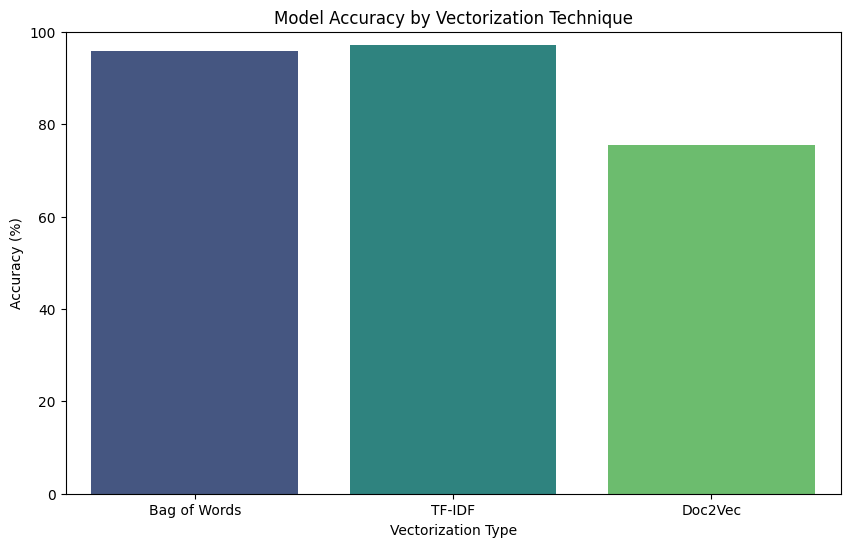

In [28]:
# Plotting results
plt.figure(figsize=(10, 6))
sns.barplot(x='Vectorization Type', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy by Vectorization Technique')
plt.xlabel('Vectorization Type')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

**Architecture: Convolutional Neural Network (CNN) for Sequence Data**

* Input Layer:
    * Embedding Layer: An embedding layer with an input dimension of 10,000 (vocabulary size) and an output dimension of 100. The input_length is set to the maximum sequence length (max_len) found in the training data.
* Convolutional Layer:
    * The model includes a 1D convolutional layer with 128 filters and a kernel size of 5. This configuration allows the model to extract spatial hierarchies of features from the sequence data. The activation function used is ReLU (Rectified Linear Unit).
* Pooling Layer:
    * Global Max Pooling 1D: Follows the convolutional layer to reduce the dimensionality of the feature maps and to extract the most significant features from the feature maps.
* Dense and Dropout Layers:
    * A dense layer with 64 neurons follows, also using the ReLU activation function.
    * A dropout layer with a rate of 0.5 is included to prevent overfitting by randomly setting input units to 0 at each step during training, which helps to improve generalization.
* Output Layer:
    * The final layer is a dense layer with a number of units equal to the number of language classes (len(language_encoder.classes_)), using a softmax activation function. This layer outputs a probability distribution over all possible classes.

**Hyperparameters:**
Same as FNN.
* Optimizer: Adam optimizer is utilized.
* Loss Function: Sparse categorical crossentropy, appropriate for classification tasks where the classes are mutually exclusive.
* Metrics: Accuracy is monitored as the primary metric to assess the performance.
* Epochs: The model is trained for 10 epochs, which determines how many times the learning algorithm will work through the entire training dataset.
* Batch Size: A batch size of 32 is chosen.
* Validation Split: 20% of the training data is used as a validation set.

**Vectorization Technique:**

* Tokenization and Padding: Text data are converted into sequences using a Tokenizer, with sequences then padded to a uniform length (max_len).

In [15]:
# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=10000)  # Adjust `num_words` as necessary
tokenizer.fit_on_texts(text_train)
X_train_seq = tokenizer.texts_to_sequences(text_train)
X_test_seq = tokenizer.texts_to_sequences(text_test)
max_len = max(max(len(x) for x in X_train_seq), max(len(x) for x in X_test_seq))  # Get max length to pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

# Define CNN model for sequence data
def build_cnn_model_for_seq(input_dim, output_dim):
    model = Sequential([
        Embedding(input_dim, 100, input_length=max_len),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_evaluate_model_cnn(X_train_padded, X_test_padded):
    model = build_cnn_model_for_seq(10000, len(language_encoder.classes_))  # 10000 is the vocabulary size
    history = model.fit(X_train_padded, encoded_labels_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    y_pred = np.argmax(model.predict(X_test_padded), axis=1)
    cnn_accuracy = accuracy_score(encoded_labels_test, y_pred)
    return cnn_accuracy * 100, history

accuracy_cnn, history_cnn = train_evaluate_model_cnn(X_train_padded, X_test_padded)

# Model Training
cnn_model = build_cnn_model_for_seq(10000, len(language_encoder.classes_))  # 10000 is the vocabulary size
cnn_model.fit(X_train_padded, encoded_labels_train, epochs=10, batch_size=32, validation_split=0.2)

# Model Evaluation
y_pred = np.argmax(cnn_model.predict(X_test_padded), axis=1)
print(f"CNN Model Accuracy with Sequences: {accuracy_cnn * 100:.2f}%")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.1800 - loss: 2.5487 - val_accuracy: 0.8579 - val_loss: 0.7945
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8192 - loss: 0.6915 - val_accuracy: 0.9528 - val_loss: 0.2058
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9444 - loss: 0.2141 - val_accuracy: 0.9625 - val_loss: 0.1593
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9614 - loss: 0.1412 - val_accuracy: 0.9589 - val_loss: 0.1480
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9672 - loss: 0.1097 - val_accuracy: 0.9583 - val_loss: 0.1498
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9717 - loss: 0.0941 - val_accuracy: 0.9583 - val_loss: 0.1532
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9720 - loss: 0.0868 - val_accuracy: 0.9625 - val_loss: 0.1397
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9762 - loss: 0.0771 - val_accuracy: 0.96

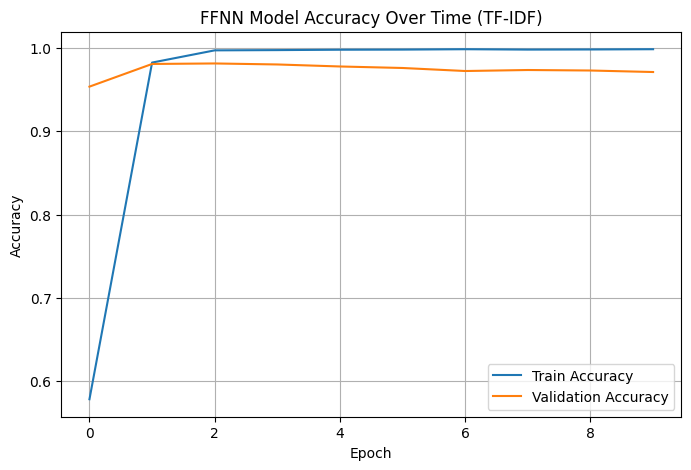

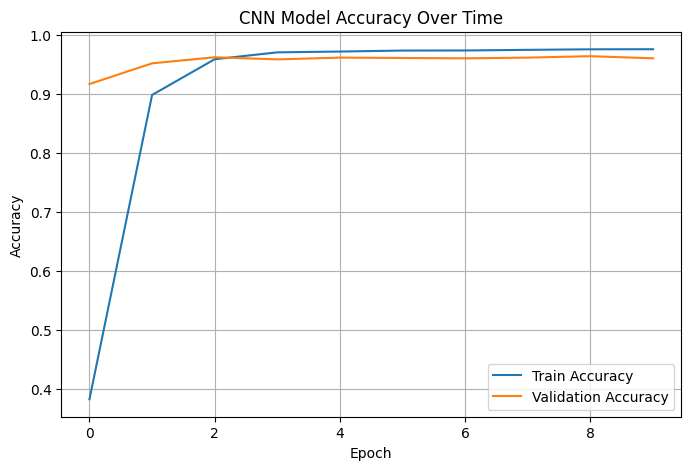

In [25]:
def plot_accuracy_over_time(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy_over_time(history_fnn, 'FFNN Model Accuracy Over Time (TF-IDF)')
plot_accuracy_over_time(history_cnn, 'CNN Model Accuracy Over Time')

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


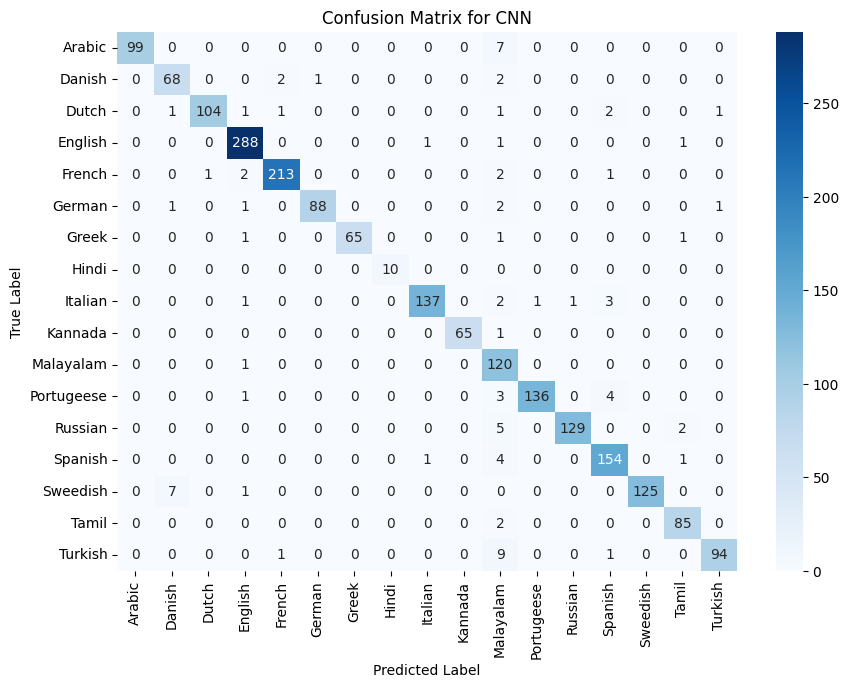

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    # Ensure classes are integer-encoded if necessary
    label_encoder = LabelEncoder()
    encoded_classes = label_encoder.fit_transform(classes)
    
    cm = confusion_matrix(y_true, y_pred, labels=encoded_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(encoded_classes), yticklabels=label_encoder.inverse_transform(encoded_classes))
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# Confusion Matrix for CNN
y_pred_cnn = np.argmax(cnn_model.predict(X_test_padded), axis=1)
plot_confusion_matrix(encoded_labels_test, y_pred_cnn, language_encoder.classes_, 'Confusion Matrix for CNN')

1. **Sentiment Analysis Setup:**
    * Tokenizer: AutoTokenizer is used to load the pre-trained tokenizer corresponding to the twitter-xlm-roberta-base-sentiment model. This tokenizer prepares text inputs for the model by converting them into the format it requires (e.g., splitting words into tokens, converting tokens to IDs).
    * Model: AutoModelForSequenceClassification loads the pre-trained sentiment model which is trained to classify texts into categories based on sentiment.
    * Pipeline: Combines the tokenizer and model into a single pipeline, simplifying the process of input preparation, model prediction, and output interpretation.
2. **Function Definition (get_sentiment):**
    * The function get_sentiment takes a list of texts and uses the sentiment analysis pipeline to predict the sentiments. It returns the results, which include the predicted sentiment label and a confidence score.

In [27]:
# Sentiment Analysis Setup
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
sentiment_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
sentiment_pipeline = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

def get_sentiment(texts):
    return sentiment_pipeline(texts)

# Example usage
sample_text = "I am done with this"
sentiment_results = get_sentiment(sample_text)
print(f"The text '{sample_text}' has sentiment: {sentiment_results}")

The text 'I am done with this' has sentiment: [{'label': 'negative', 'score': 0.8533114790916443}]


# Conclusion

This project focused on developing and evaluating machine learning models for the task of language detection across a diverse dataset. Utilizing various vectorization methods—Bag of Words, TF-IDF, and Doc2Vec—we explored their impact on model performance. The Feedforward Neural Network (FNN) and Convolutional Neural Network (CNN) were the primary architectures used for classification.

**Model Performance and Observations:**

1. TF-IDF with FNN achieved the highest accuracy of 97.2%.
2. Bag of Words, also implemented with an FNN, provided nearly comparable results with an accuracy of 96.6%. This indicates that frequency-based features are also highly effective for this task.
3. Doc2Vec, while innovative in capturing semantic and contextual information, lagged in performance, achieving an accuracy of 74.95%. This could be due to the complexity of language data and the model's inability to capture all nuances effectively in a dense, fixed-sized vector.
4. CNN with sequence data showed a robust performance with an accuracy of 95.7%. The CNN's ability to extract localized patterns makes it a strong contender for text-based tasks, although it slightly underperformed compared to the TF-IDF model. According to the confusion Matrix, Malaysian was the problematic language that the model was giving false positive.
5. The accuracy over time for both the FNN and CNN models showed quick convergence, indicating that the models were well-suited to the task with adequate training epochs. Notably, the validation accuracies closely tracked the training accuracies, suggesting good generalization without significant overfitting.

**Further Insights:**

1. While scores of the models are high, it would have been interesting if we also looked at the answers of the models that were wrong and did edge case analysis. For example, Malaysian had a notable problem with CNN.